In [47]:
import pandas as pd
import os
import sklearn
import math
import joblib
from sklearn import ensemble 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import impute
from sklearn import pipeline
from sklearn import compose
from sklearn import feature_selection
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics
from sklearn.compose import TransformedTargetRegressor
from feature_engine.selection import DropDuplicateFeatures, DropCorrelatedFeatures
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from shutil import rmtree

In [48]:
warnings.filterwarnings('ignore')
sklearn.set_config(display="diagram")
dir = "C:/Users/pc/Downloads/ai-level1/house-prices"
cachedir = os.path.join(dir, "pipeline_cache")

In [49]:
house_train = pd.read_csv(os.path.join(dir, "train.csv"))
house_train.shape
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [50]:
#Create new features
house_train['TotalSF'] = house_train['TotalBsmtSF'] + house_train['GrLivArea'] + house_train['1stFlrSF'] + house_train['2ndFlrSF']
house_train['TotalBathRooms'] = house_train['FullBath'] + house_train['BsmtFullBath'] + 0.5 * house_train['HalfBath'] +  0.5 * house_train['BsmtHalfBath']
house_train['TotalPorchSF'] = house_train['OpenPorchSF'] + house_train['3SsnPorch'] + house_train['EnclosedPorch'] + house_train['ScreenPorch']

In [51]:
def cont_selector(df):
    return df.select_dtypes(include=['number']).columns

def cat_selector(df):
    return df.select_dtypes(exclude=['number']).columns

def cast_to_cat(df, features):
    for feature in features:
        df[feature] = df[feature].astype('category')

In [52]:
print(cont_selector(house_train))
print(cat_selector(house_train))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalSF', 'TotalBathRooms',
       'TotalPorchSF'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure',

In [53]:
features_to_cast = ["MSSubClass"]
features_to_cast.extend(cat_selector(house_train))
cast_to_cat(house_train, features_to_cast)
print(cont_selector(house_train))
print(cat_selector(house_train))

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'TotalSF', 'TotalBathRooms',
       'TotalPorchSF'],
      dtype='object')
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',

In [54]:
def get_features_to_drop_on_missingdata(df, threshold) :
    tmp = df.isnull().sum()
    return list(tmp[tmp/float(df.shape[0]) > threshold].index)

def drop_features(df, features):
    return df.drop(features, axis=1, inplace=True)

In [55]:
missing_data_features_to_drop = get_features_to_drop_on_missingdata(house_train, 0.25)
print(missing_data_features_to_drop)
drop_features(house_train, missing_data_features_to_drop)
house_train.info()

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1460 non-null   int64   
 1   MSSubClass      1460 non-null   category
 2   MSZoning        1460 non-null   category
 3   LotFrontage     1201 non-null   float64 
 4   LotArea         1460 non-null   int64   
 5   Street          1460 non-null   category
 6   LotShape        1460 non-null   category
 7   LandContour     1460 non-null   category
 8   Utilities       1460 non-null   category
 9   LotConfig       1460 non-null   category
 10  LandSlope       1460 non-null   category
 11  Neighborhood    1460 non-null   category
 12  Condition1      1460 non-null   category
 13  Condition2      1460 non-null   category
 14  BldgType        1460 non-null   category
 15  HouseStyle      1460 non-null   c

In [56]:
target = house_train['SalePrice']
features_to_drop = ['Id', 'SalePrice']
drop_features(house_train, features_to_drop)
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   MSSubClass      1460 non-null   category
 1   MSZoning        1460 non-null   category
 2   LotFrontage     1201 non-null   float64 
 3   LotArea         1460 non-null   int64   
 4   Street          1460 non-null   category
 5   LotShape        1460 non-null   category
 6   LandContour     1460 non-null   category
 7   Utilities       1460 non-null   category
 8   LotConfig       1460 non-null   category
 9   LandSlope       1460 non-null   category
 10  Neighborhood    1460 non-null   category
 11  Condition1      1460 non-null   category
 12  Condition2      1460 non-null   category
 13  BldgType        1460 non-null   category
 14  HouseStyle      1460 non-null   category
 15  OverallQual     1460 non-null   int64   
 16  OverallCond     1460 non-null   int64   
 17  YearBuilt     

In [57]:
#define train, target data and metric
X_train = house_train
y_train = target
scoring = metrics.make_scorer(metrics.root_mean_squared_log_error, greater_is_better=False)

In [93]:
# preprocessing pipeline for linear estimator
steps = [('imp', impute.SimpleImputer(strategy="most_frequent")), ('ohe', preprocessing.OneHotEncoder(sparse_output=False,  handle_unknown='ignore'))]
cat_linear_preprocessor = pipeline.Pipeline(steps)

steps = [('imp', impute.SimpleImputer()), ('scaler', preprocessing.StandardScaler())]
cont_linear_preprocessor = pipeline.Pipeline(steps)

linear_preprocessor = compose.ColumnTransformer(
    [ ("categorical", cat_linear_preprocessor, cat_selector(house_train)), ("continuous", cont_linear_preprocessor, cont_selector(house_train)) ]
)

In [59]:
#lasso pipeline-I
lasso_pipeline1 = pipeline.Pipeline([  
                    ('linear_preprocessor', linear_preprocessor),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('lasso', linear_model.Lasso())
                ], memory=cachedir)
lasso_pipeline1

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()), ('lasso', Lasso())])

In [60]:
#grid search of lasso pipeline-I
lasso_pipeline_params = {
                'lasso__alpha':[0, 0.0001, 0.0005, 0.0007, 0.0008, 0.0009, 0.001, 0.005, 0.05, 0.5, 0.75, 1, 2, 5, 10, 20]
            }
cv = model_selection.KFold(10)
lasso_pipeline_grid1 = model_selection.GridSearchCV(lasso_pipeline1, lasso_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
lasso_pipeline_grid1.fit(X_train, y_train)
print(lasso_pipeline_grid1.best_params_)
print(lasso_pipeline_grid1.best_score_)
print(lasso_pipeline_grid1.best_estimator_)

{'lasso__alpha': 20}
-0.16329855338728466
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'Wo

In [61]:
#lasso pipeline-II
target_transformer = preprocessing.PowerTransformer(method='box-cox')

lasso_with_trans_target = TransformedTargetRegressor(
    regressor = linear_model.Lasso(),
    transformer= target_transformer
)
lasso_pipeline2 = pipeline.Pipeline([  
                    ('linear_preprocessor', linear_preprocessor),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('lasso', lasso_with_trans_target)
                ], memory=cachedir)
lasso_pipeline2

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('lasso',
                 TransformedTargetRegressor(regressor=Lasso(),
                                            transformer=PowerTransformer(method='box-cox')))])

In [62]:
#grid search of lasso pipeline-II
lasso_pipeline_params = {
                'lasso__regressor__alpha':[0, 0.0001, 0.0005, 0.0007, 0.0008, 0.0009, 0.001, 0.005, 0.05, 0.5, 0.75, 1, 2, 5, 10, 20]
            }
cv = model_selection.KFold(10)
lasso_pipeline_grid2 = model_selection.GridSearchCV(lasso_pipeline2, lasso_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
lasso_pipeline_grid2.fit(X_train, y_train)
print(lasso_pipeline_grid2.best_params_)
print(lasso_pipeline_grid2.best_score_)
print(lasso_pipeline_grid2.best_estimator_)

{'lasso__regressor__alpha': 0.001}
-0.13332526697026645
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'S

In [86]:
# preprocessing pipeline for linear estimator(skew handling)
steps = [('imp', impute.SimpleImputer(strategy="most_frequent")), ('ohe', preprocessing.OneHotEncoder(sparse_output=False,  handle_unknown='ignore'))]
cat_linear_preprocessor_skew = pipeline.Pipeline(steps)

steps = [('imp', impute.SimpleImputer()), ('skew', preprocessing.QuantileTransformer(output_distribution='normal'))]
cont_linear_preprocessor_skew = pipeline.Pipeline(steps)

linear_preprocessor_skew = compose.ColumnTransformer(
    [ ("categorical", cat_linear_preprocessor_skew, cat_selector(house_train)), ("continuous", cont_linear_preprocessor_skew, cont_selector(house_train)) ]
)

In [87]:
#lasso pipeline-III
lasso_with_trans_target = TransformedTargetRegressor(
    regressor = linear_model.Lasso(),
    transformer= target_transformer
)
lasso_pipeline3 = pipeline.Pipeline([  
                    ('linear_preprocessor', linear_preprocessor_skew),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('lasso', lasso_with_trans_target)
                ], memory=cachedir)
lasso_pipeline3

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('lasso',
                 TransformedTargetRegressor(regressor=Lasso(),
                                            transformer=PowerTransformer(method='box-cox')))])

In [88]:
#grid search of lasso pipeline-III
lasso_pipeline_params = {
                'lasso__regressor__alpha':[0, 0.0001, 0.0005, 0.0007, 0.0008, 0.0009, 0.001, 0.005, 0.05, 0.5, 0.75, 1, 2, 5, 10, 20]
            }
cv = model_selection.KFold(10)
lasso_pipeline_grid3 = model_selection.GridSearchCV(lasso_pipeline3, lasso_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
lasso_pipeline_grid3.fit(X_train, y_train)
print(lasso_pipeline_grid3.best_params_)
print(lasso_pipeline_grid3.best_score_)
print(lasso_pipeline_grid3.best_estimator_)

{'lasso__regressor__alpha': 0.001}
-0.12232334480742357
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'S

In [91]:
feature_names = lasso_pipeline_grid2.best_estimator_[0].get_feature_names_out()
print(len(feature_names), feature_names)
feature_names = lasso_pipeline_grid2.best_estimator_[1].get_feature_names_out(input_features = feature_names)
print(len(feature_names), feature_names)

283 ['categorical__MSSubClass_20' 'categorical__MSSubClass_30'
 'categorical__MSSubClass_40' 'categorical__MSSubClass_45'
 'categorical__MSSubClass_50' 'categorical__MSSubClass_60'
 'categorical__MSSubClass_70' 'categorical__MSSubClass_75'
 'categorical__MSSubClass_80' 'categorical__MSSubClass_85'
 'categorical__MSSubClass_90' 'categorical__MSSubClass_120'
 'categorical__MSSubClass_160' 'categorical__MSSubClass_180'
 'categorical__MSSubClass_190' 'categorical__MSZoning_C (all)'
 'categorical__MSZoning_FV' 'categorical__MSZoning_RH'
 'categorical__MSZoning_RL' 'categorical__MSZoning_RM'
 'categorical__Street_Grvl' 'categorical__Street_Pave'
 'categorical__LotShape_IR1' 'categorical__LotShape_IR2'
 'categorical__LotShape_IR3' 'categorical__LotShape_Reg'
 'categorical__LandContour_Bnk' 'categorical__LandContour_HLS'
 'categorical__LandContour_Low' 'categorical__LandContour_Lvl'
 'categorical__Utilities_AllPub' 'categorical__Utilities_NoSeWa'
 'categorical__LotConfig_Corner' 'categorical__

,importance
feature,
continuous__GarageArea,0.045122
continuous__Fireplaces,0.045400
categorical__Exterior1st_MetalSd,0.046530
categorical__SaleCondition_Normal,0.047021
categorical__MSSubClass_60,0.050373
categorical__SaleType_COD,0.053465
categorical__ExterCond_TA,0.055364
categorical__BldgType_1Fam,0.058077
categorical__Heating_GasW,0.058336


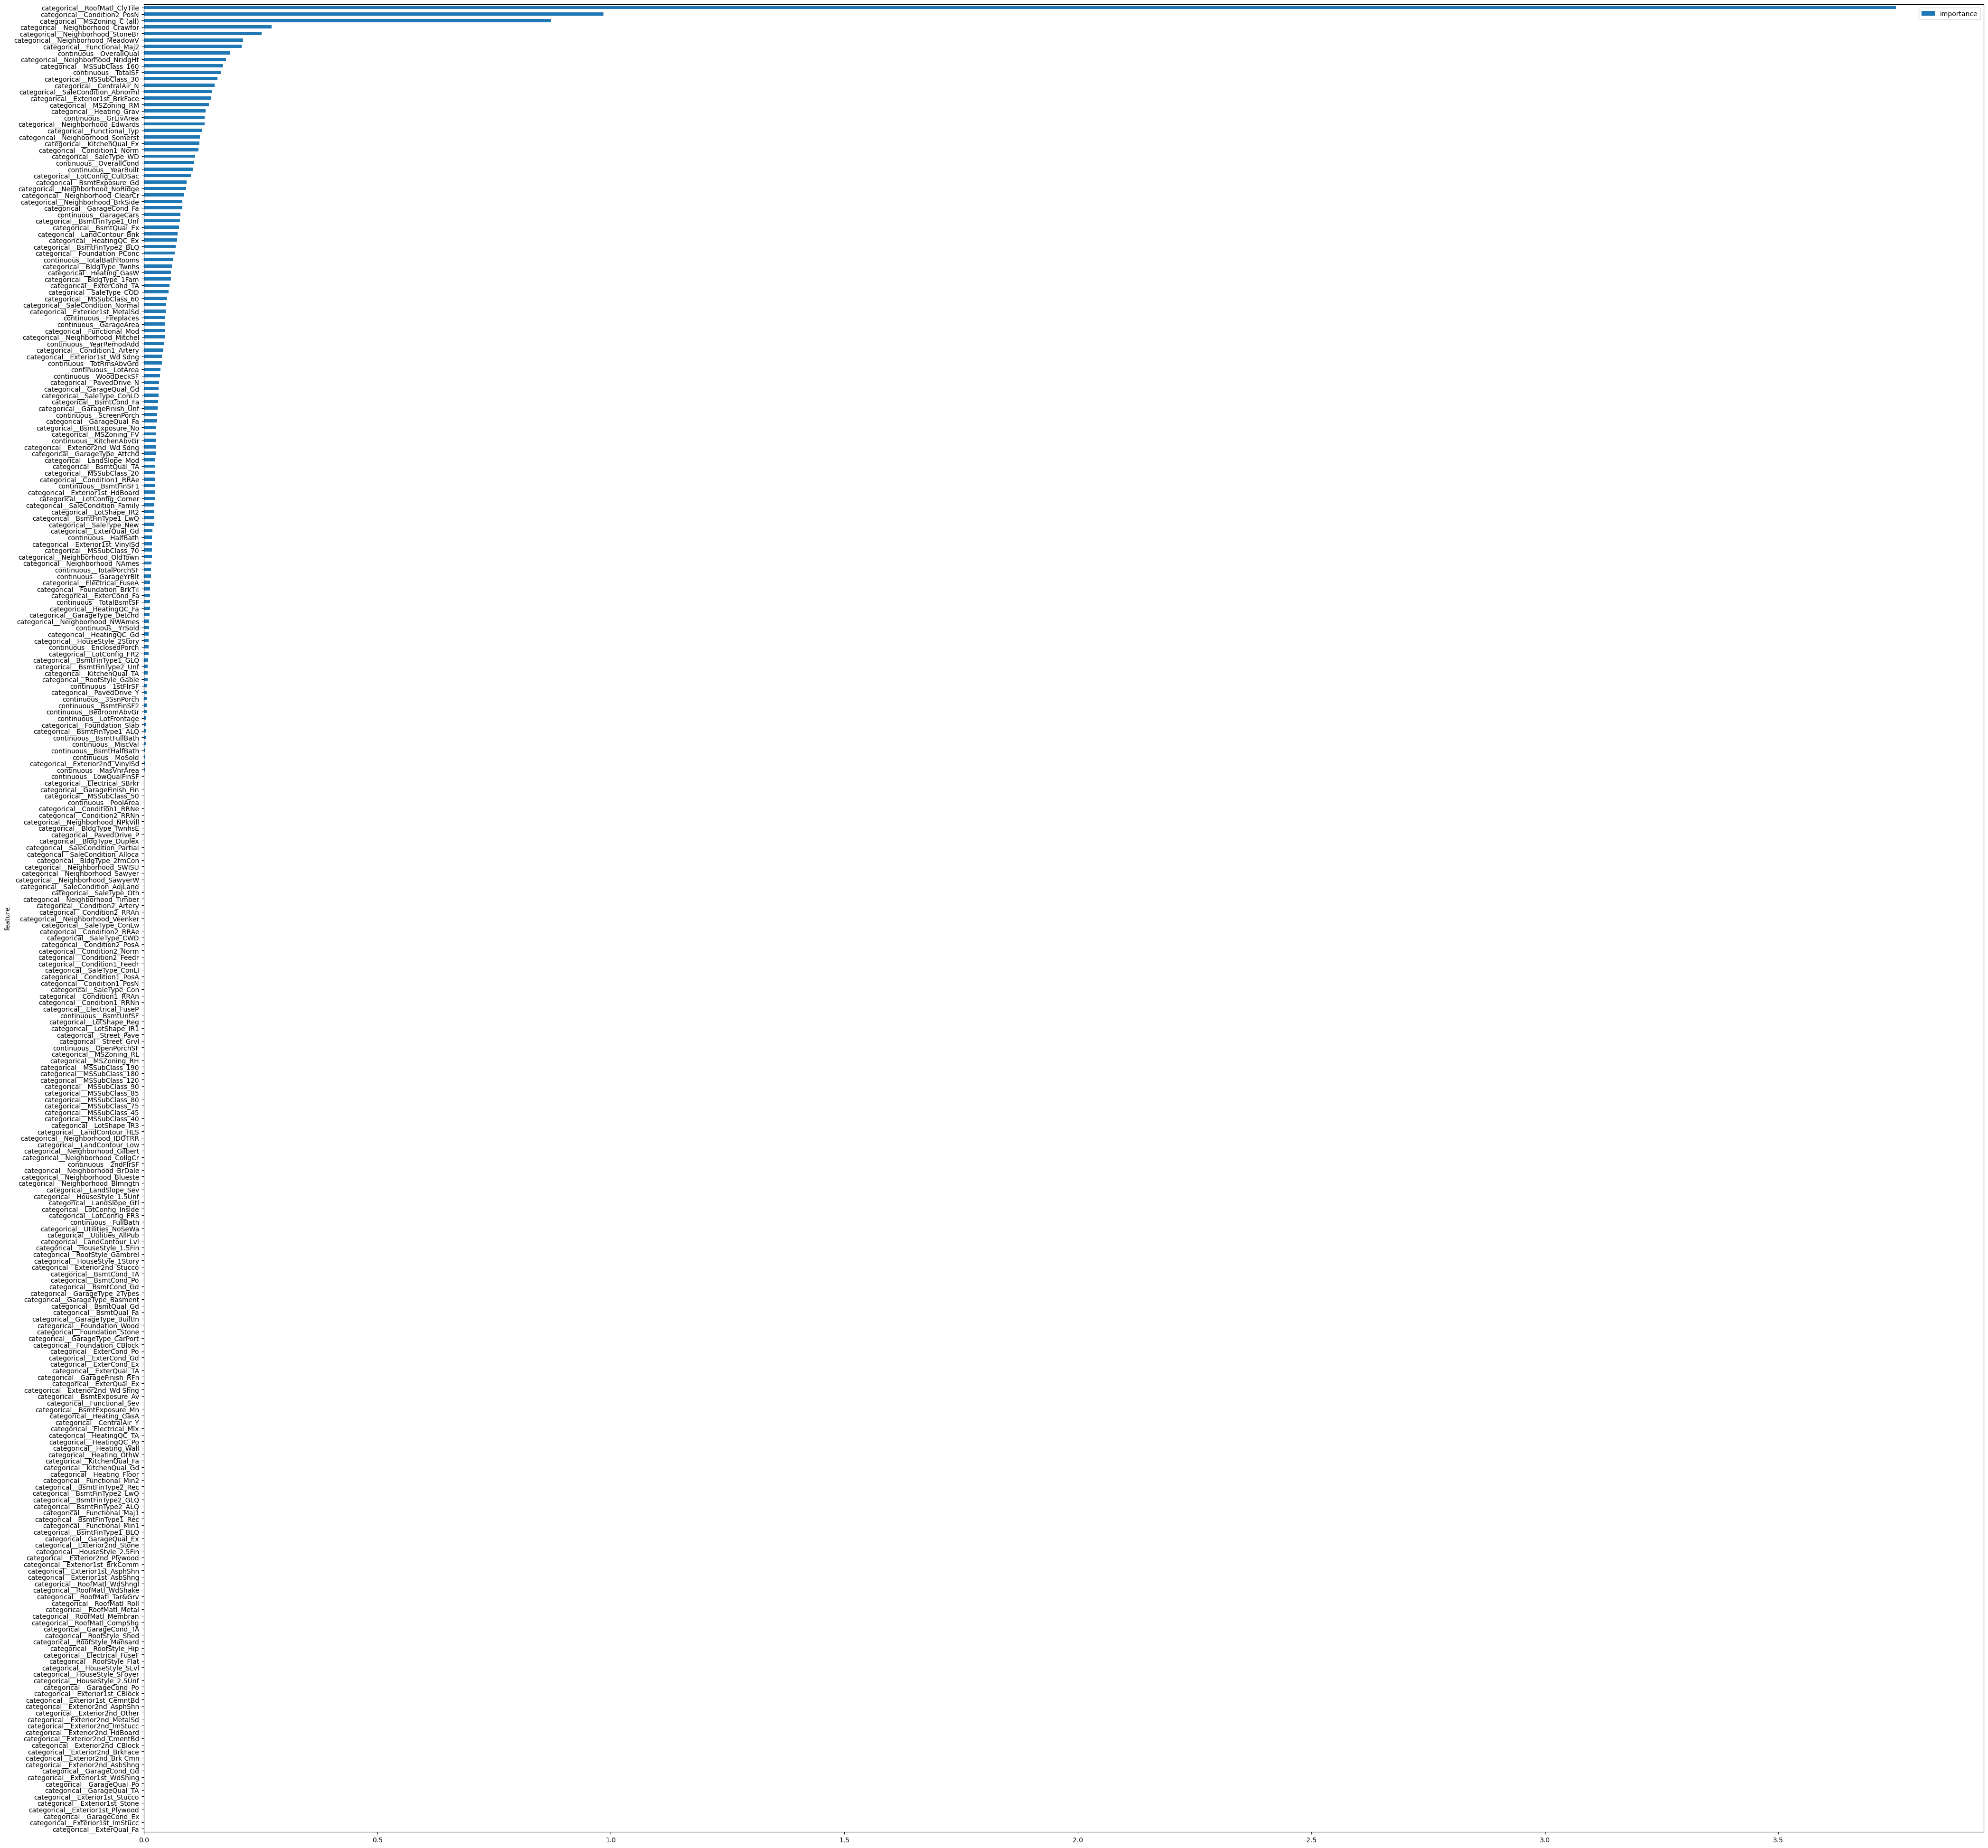

In [92]:
def plot_feature_importances(model, feature_names):
    features = pd.DataFrame({'feature': feature_names, 'importance':np.abs(model.coef_)})
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    features.plot(kind='barh', figsize=(50, 50))
    return features
    
tmp = plot_feature_importances(lasso_pipeline_grid2.best_estimator_[2].regressor_, feature_names)
tmp.tail(50)

In [94]:
#ridge pipeline
ridge_with_trans_target = TransformedTargetRegressor(
    regressor = linear_model.Ridge(),
    transformer= target_transformer
)
ridge_pipeline = pipeline.Pipeline([  
                    ('linear_preprocessor', linear_preprocessor),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('ridge', ridge_with_trans_target)
                ], memory=cachedir)
ridge_pipeline

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('ridge',
                 TransformedTargetRegressor(regressor=Ridge(),
                                            transformer=PowerTransformer(method='box-cox')))])

In [95]:
#grid search of ridge pipeline
ridge_pipeline_params = {
                'ridge__regressor__alpha':[0, 0.0001, 0.0005, 0.0007, 0.0008, 0.0009, 0.001, 0.005, 0.05, 0.5, 0.75, 1, 2, 5, 10, 20]
            }
cv = model_selection.KFold(10)
ridge_pipeline_grid = model_selection.GridSearchCV(ridge_pipeline, ridge_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
ridge_pipeline_grid.fit(X_train, y_train)
print(ridge_pipeline_grid.best_params_)
print(ridge_pipeline_grid.best_score_)
print(ridge_pipeline_grid.best_estimator_)

{'ridge__regressor__alpha': 10}
-0.13618706222418892
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('linear_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandConto...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'Scre

,importance
feature,
categorical__GarageCond_Fa,0.084397
categorical__BsmtQual_Ex,0.085012
categorical__Condition1_RRAe,0.086077
categorical__CentralAir_Y,0.088731
categorical__CentralAir_N,0.088731
categorical__BsmtFinType2_BLQ,0.089134
categorical__LandContour_Bnk,0.089699
continuous__YearBuilt,0.090367
categorical__GarageQual_Fa,0.091095


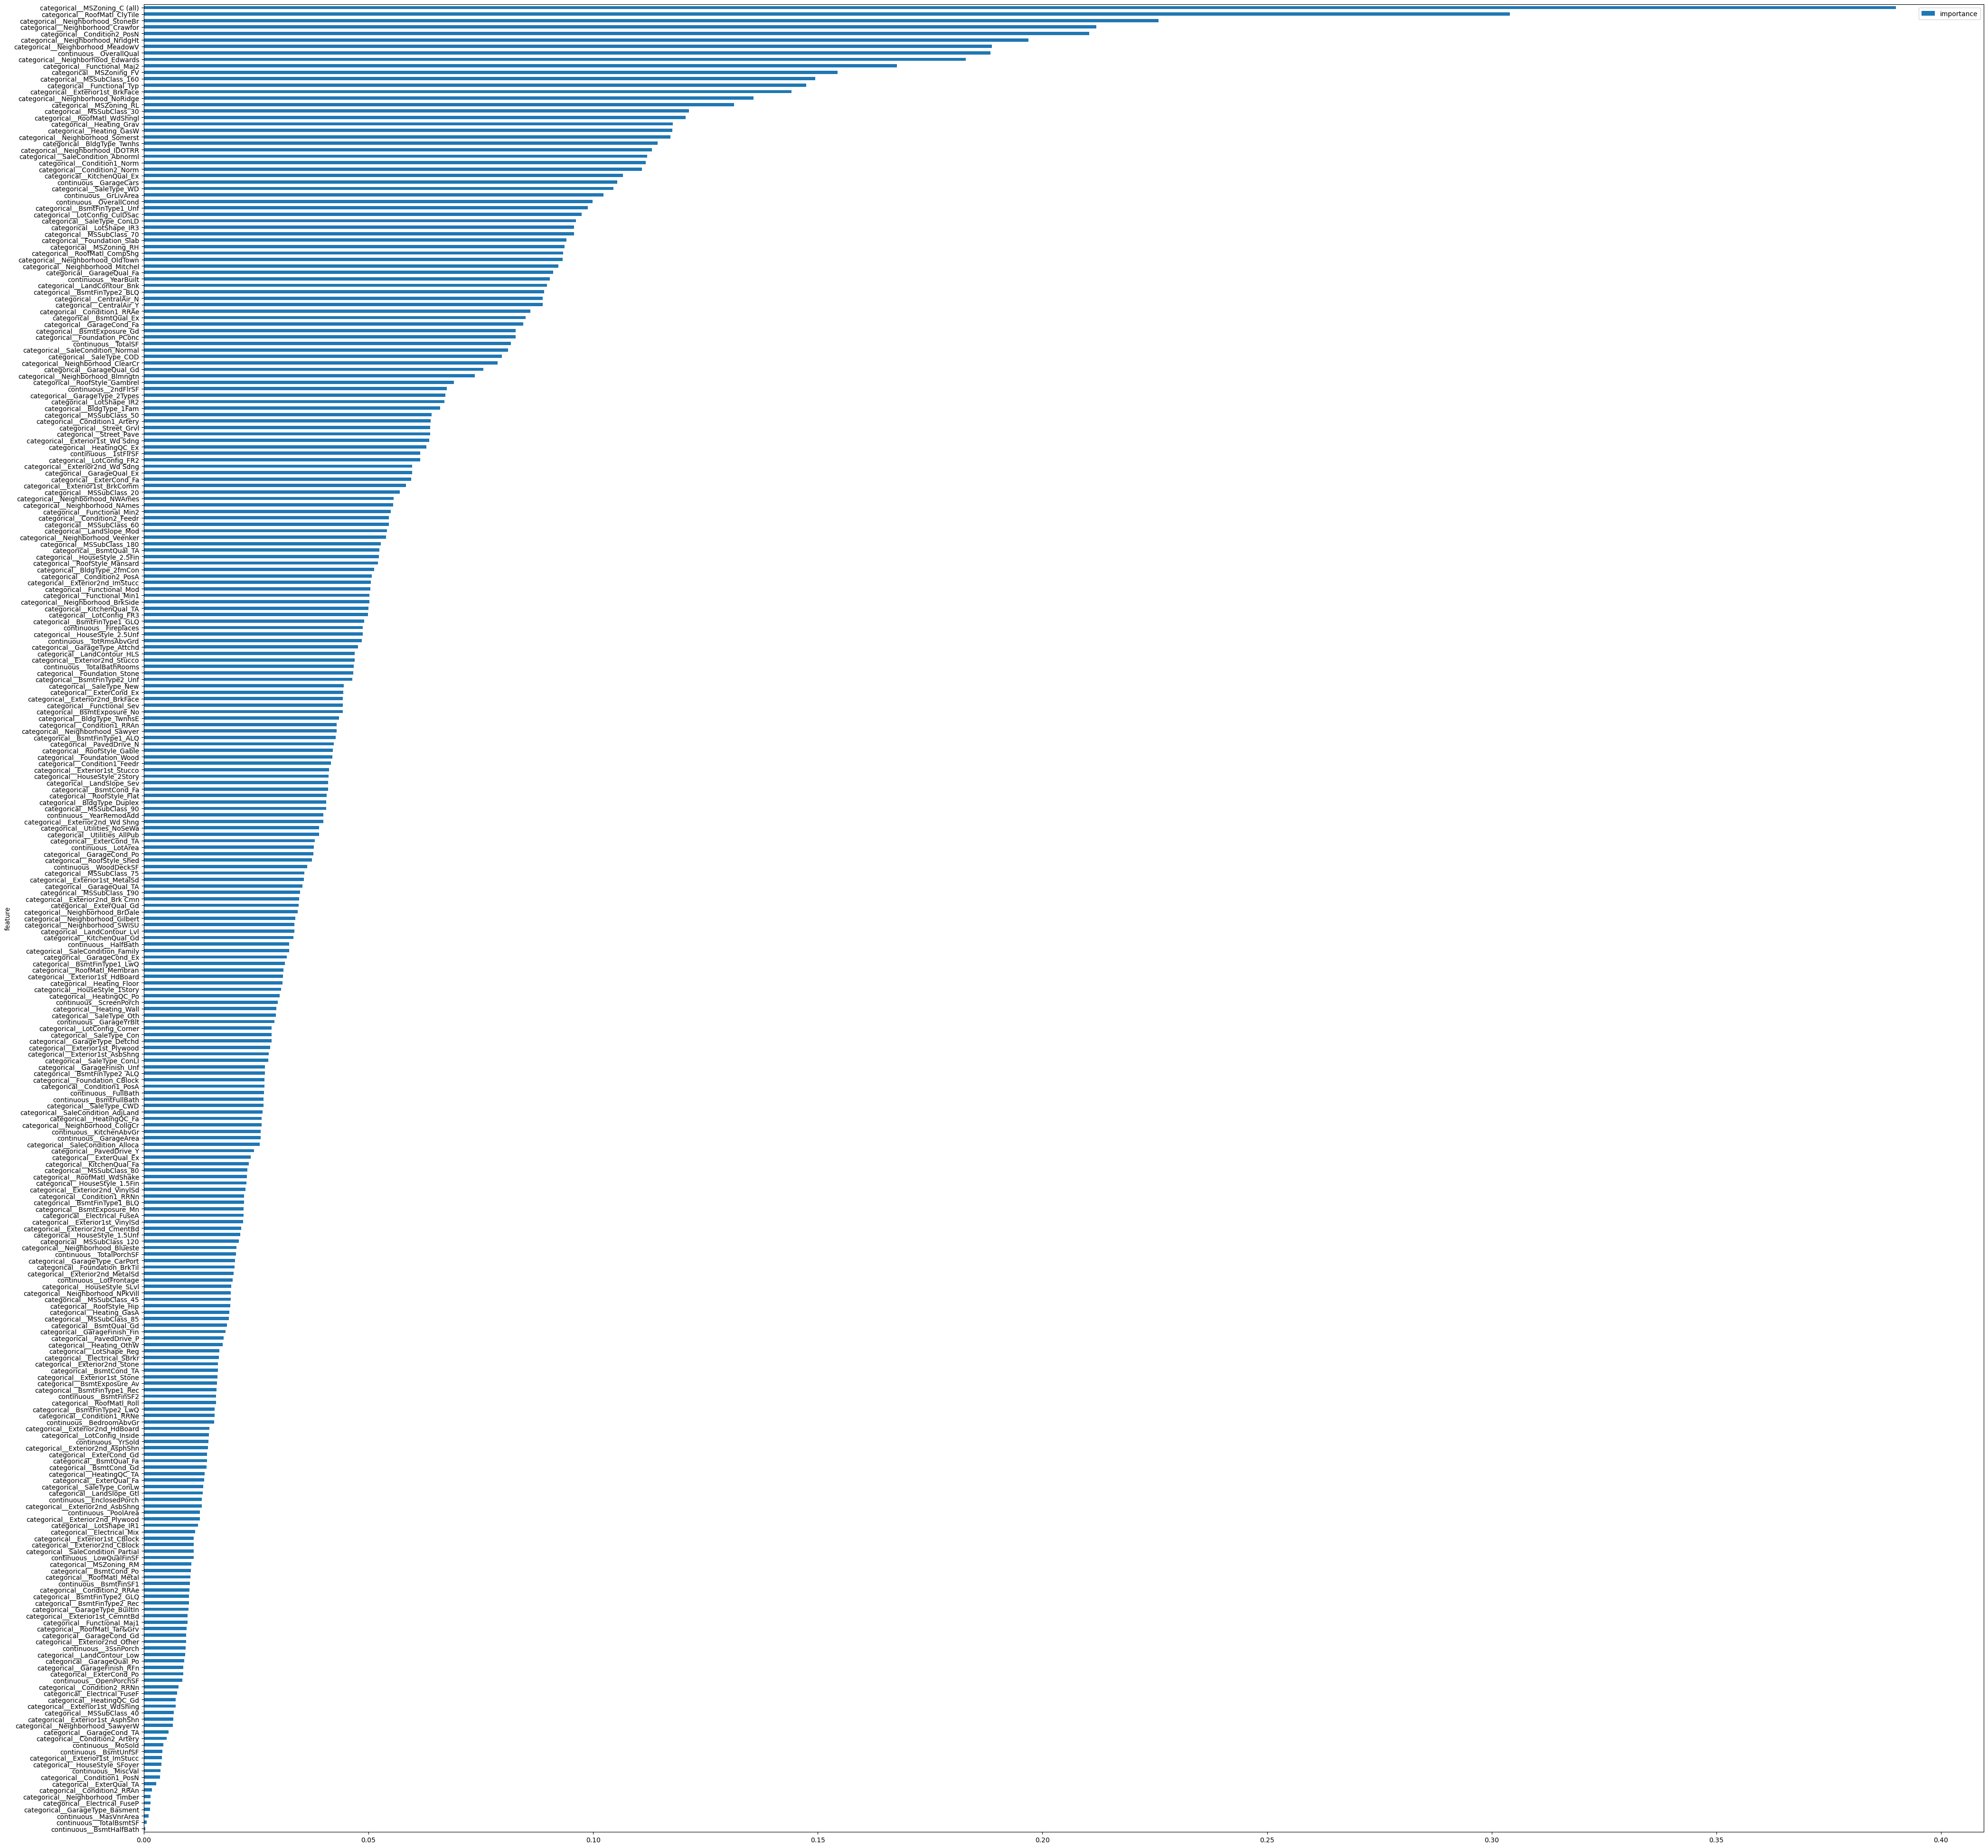

In [98]:
tmp = plot_feature_importances(ridge_pipeline_grid.best_estimator_[2].regressor_, feature_names)
tmp.tail(50)

In [99]:
joblib.dump(lasso_pipeline_grid2.best_estimator_, os.path.join(dir, "houseprice_lasso.pkl"))
joblib.dump(ridge_pipeline_grid.best_estimator_, os.path.join(dir, "houseprice_ridge.pkl"))

['C:/Users/pc/Downloads/ai-level1/house-prices\\houseprice_ridge.pkl']

In [76]:
house_test = pd.read_csv(os.path.join(dir, "test.csv"))
print(house_test.shape)
house_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [77]:
#Create new features
house_test['TotalSF'] = house_test['TotalBsmtSF'] + house_test['GrLivArea'] + house_test['1stFlrSF'] + house_train['2ndFlrSF']
house_test['TotalBathRooms'] = house_test['FullBath'] + house_test['BsmtFullBath'] + 0.5 * house_test['HalfBath'] +  0.5 * house_test['BsmtHalfBath']
house_test['TotalPorchSF'] = house_test['OpenPorchSF'] + house_test['3SsnPorch'] + house_test['EnclosedPorch'] + house_test['ScreenPorch']

In [78]:
cast_to_cat(house_test, features_to_cast)

In [79]:
house_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1459 non-null   int64   
 1   MSSubClass      1459 non-null   category
 2   MSZoning        1455 non-null   category
 3   LotFrontage     1232 non-null   float64 
 4   LotArea         1459 non-null   int64   
 5   Street          1459 non-null   category
 6   Alley           107 non-null    category
 7   LotShape        1459 non-null   category
 8   LandContour     1459 non-null   category
 9   Utilities       1457 non-null   category
 10  LotConfig       1459 non-null   category
 11  LandSlope       1459 non-null   category
 12  Neighborhood    1459 non-null   category
 13  Condition1      1459 non-null   category
 14  Condition2      1459 non-null   category
 15  BldgType        1459 non-null   category
 16  HouseStyle      1459 non-null   category
 17  OverallQual   

In [80]:
drop_features(house_test, missing_data_features_to_drop)

In [96]:
house_test['SalePrice'] = np.round(ridge_pipeline_grid.best_estimator_.predict(house_test), 2)
house_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,TotalBathRooms,TotalPorchSF,SalePrice
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,6,2010,WD,Normal,3528.0,1.0,120,116610.64
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,12500,6,2010,WD,Normal,3987.0,1.5,36,145059.39
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,3,2010,WD,Normal,4351.0,2.5,34,170617.29
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,0,0,6,2010,WD,Normal,4212.0,2.5,36,192736.01
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,0,0,1,2010,WD,Normal,4893.0,2.0,226,207697.87


In [97]:
house_test.to_csv(os.path.join(dir, "house_prices_submit.csv"), columns=["Id", "SalePrice"], index=False)

In [92]:
rmtree(cachedir)